# [NTDS'18] milestone 3: spectral graph theory
[ntds'18]: https://github.com/mdeff/ntds_2018

[Michaël Defferrard](http://deff.ch), [EPFL LTS2](https://lts2.epfl.ch)

## Students

* Team: `10`
* Students: `Cionca Alexandre, de Goumoëns Frédéric, Donzier Paul, Fluhr Hugo`
* Dataset: `TMDb dataset (subset from IMDb)`

## Rules

* Milestones have to be completed by teams. No collaboration between teams is allowed.
* Textual answers shall be short. Typically one to two sentences.
* Code has to be clean.
* You cannot import any other library than we imported.
* When submitting, the notebook is executed and the results are stored. I.e., if you open the notebook again it should show numerical results and plots. We won't be able to execute your notebooks.
* The notebook is re-executed from a blank state before submission. That is to be sure it is reproducible. You can click "Kernel" then "Restart & Run All" in Jupyter.

## Objective

The goal of this milestone is to get familiar with the graph Laplacian and its spectral decomposition.

## 0 Load your network

In [109]:
%matplotlib inline

If you get a `No module named 'sklearn'` error when running the below cell, install [scikit-learn](https://scikit-learn.org) with `conda install scikit-learn` (after activating the `ntds_2018` environment).

In [110]:
import numpy as np
from scipy import sparse
import scipy.sparse.linalg
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

import pandas as pd
import json

Let's denote your graph as $\mathcal{G} = (\mathcal{V}, \mathcal{E}, A)$, where $\mathcal{V}$ is the set of nodes, $\mathcal{E}$ is the set of edges, $A \in \mathbb{R}^{N \times N}$ is the (weighted) adjacency matrix, and $N = |\mathcal{V}|$ is the number of nodes.

Import the adjacency matrix $A$ that you constructed in the first milestone.
(You're allowed to update it between milestones if you want to.)

In [111]:
adjacency =  np.load("../Milestone_1/saved_adjacency_M3.npy")
n_nodes =  len(adjacency)

In [112]:
# We reload our dataframe in order to analyse the clustering

features = pd.read_csv("../Milestone_1/saved_features_M3.csv")


# Loading json columns in case we need to access some elements
json_columns = ['genres','crew','production_companies','production_countries']
for column in json_columns:
     features[column] = features[column].apply(json.loads)
        
# Creating a column that will contain the genres of each movie, useful to assess quality of clustering
features['genres_name']=""

for i in range(len(features.title)):
    strs=[]
    for ii in range(len(features.genres[i])):
        strs.append(features.genres[i][ii].get('name'))
    features.at[i,'genres_name']=strs

features = features.drop(columns='Unnamed: 0')

## 1 Graph Laplacian

### Question 1

From the (weighted) adjacency matrix $A$, compute both the combinatorial (also called unnormalized) and the normalized graph Laplacian matrices.

Note: if your graph is weighted, use the weighted adjacency matrix. If not, use the binary adjacency matrix.

For efficient storage and computation, store these sparse matrices in a [compressed sparse row (CSR) format](https://en.wikipedia.org/wiki/Sparse_matrix#Compressed_sparse_row_.28CSR.2C_CRS_or_Yale_format.29).

In [113]:
degrees = np.sum(adjacency,0)

# Our matrix is defined such that it contains no disconnected nodes
D_sqrt_inv = np.diag(1/np.sqrt(degrees))

laplacian_combinatorial =  sparse.csr_matrix(np.diag(degrees)-adjacency)
laplacian_normalized =  sparse.csr_matrix(D_sqrt_inv @ laplacian_combinatorial @ D_sqrt_inv)

Use one of them as the graph Laplacian $L$ for the rest of the milestone.
We however encourage you to run the code with both to get a sense of the difference!

In [114]:
laplacian = laplacian_normalized

### Question 2

Compute the eigendecomposition of the Laplacian $L = U \Lambda U^\top$, where the columns $u_k \in \mathbb{R}^N$ of $U = [u_1, \dots, u_N] \in \mathbb{R}^{N \times N}$ are the eigenvectors and the diagonal elements $\lambda_k = \Lambda_{kk}$ are the corresponding eigenvalues.

Make sure that the eigenvalues are ordered, i.e., $0 = \lambda_1 \leq \lambda_2 \leq \dots \leq \lambda_N$.

In [115]:
_ , eigenvectors =  np.linalg.eigh(laplacian.toarray())
eigenvalues, _ =  np.linalg.eigh(laplacian.toarray())

assert eigenvectors.shape == (n_nodes, n_nodes)

Justify your choice of eigensolver.

We tried the solvers from Scipy.linalg and Numpy.linalg optimised for Hermitian matrices and compared their perfomances with the magic %timeit. Numpy was faster.

### Question 3

We can write $L = S S^\top$. What is the matrix $S$? What does $S^\top x$, with $x \in \mathbb{R}^N$, compute?

S is the incidence matrix. It contains the information about the orientation of the edges, it gives a correspondace between
vertices and edges. S is of size N x M, N being number of vertices and M number of edges. S(i,j)= +1 / -1 if node i is 
the outgoing / ingoing node of edge j, S(i,j)= 0 othewise.
$S^\top x$ computes the gradient of x. It gives the derivative of x at each edge, $S^\top x$ is a vector of size M.

### Question 4

Show that $\lambda_k = \| S^\top u_k \|_2^2$, where $\| \cdot \|_2^2$ denotes the squared Euclidean norm (a.k.a. squared $L^2$ norm).

Remembering that $L = S S^\top $ and that $\| S^\top u_k \|_2^2 = u_k^\top S S^\top u_k  $. We use the definition of eigenvalues and eigenvectors :

$L u_k = \lambda_k u_k$

Left-multiplying both sides by $u_k^\top$ gives :

$ u_k^\top L u_k = u_k^\top \lambda_k u_k$

$\lambda_k $ being a scalar we can rewrite :

$ u_k^\top L u_k = \lambda_k u_k^\top  u_k$

Assuming that the eigenvectors are normalized (which is the case for most eigensolvers) we get :

$ u_k^\top L u_k = \lambda_k $

Which is equivalent to :

$ \lambda_k = u_k^\top L u_k = u_k^\top S S^\top u_k = \| S^\top u_k \|_2^2 $



What does the quantity $\| S^\top x \|_2^2$ tell us about $x$?

This quantity is the square of the norm of the gradient of x, meaning that it tells us how much the signal x varies over the graph.
It is an indicator of the smoothness of x over the graph.

### Question 5

What is the value of $u_0$, both for the combinatorial and normalized Laplacians?

For the combinatorial Laplacian, $u_0$ is the indicating vector of the first connected component. It contains 1's (normalized by n_nodes) for vertices contained in the component and 0's otherwise.
For the normalized Laplacian, $u_0$ is $u_0$ of the combinatorial Laplacian scaled by the degrees.

### Question 6

Look at the spectrum of the Laplacian by plotting the eigenvalues.
Comment on what you observe.

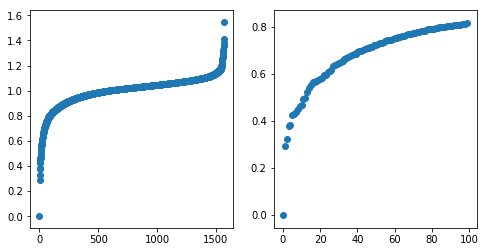

In [116]:
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.scatter(range(len(eigenvalues)), eigenvalues)
plt.subplot(1,2,2)
plt.scatter(range(len(eigenvalues[:100])), eigenvalues[:100])

**Your answer here.**

Zooming at the 100 lower eigenvalue, we can see a distinct gap around the 5th and the 10th eigenvalues. Such informations shows that our network may be classified in 5 (or 10) different clusters. Moreover, there's only one eigenvalue equal to zero ($\lambda_0$ has multiplicity one) which means that our graph has only one connected component.

How many connected components are there in your graph? Answer using the eigenvalues only.

In [117]:
# The number of connected components is equal to the multiplicity of the eigenvalue 0
# Since the eigensolver has a finite precision, we consider to be 0 values inferior to 1e-5
nb_connected_components = len(np.argwhere(eigenvalues < 1e-5))

print ('Our graph contains', nb_connected_components, 'connected components.')

Our graph contains 1 connected components.


Is there an upper bound on the eigenvalues, i.e., what is the largest possible eigenvalue? Answer for both the combinatorial and normalized Laplacians.

**Your answer here.**

TO BE DONE (JE FAIS PAS (:D))

## 3 Laplacian eigenmaps

*Laplacian eigenmaps* is a method to embed a graph $\mathcal{G}$ in a $d$-dimensional Euclidean space.
That is, it associates a vector $z_i \in \mathbb{R}^d$ to every node $v_i \in \mathcal{V}$.
The graph $\mathcal{G}$ is thus embedded as $Z \in \mathbb{R}^{N \times d}$.

From now on, if your graph has more than one connected component, work with the giant component only.

In [118]:
# We start by extracting the giant component of our graph
# This is achieved by using the first eigenvector as indicator of the giant component
idx=np.where(np.abs(eigenvectors[:,1]) <1e-5 , 0, 1)
# create an array containing the index of the nodes which are not in the giant component
idx_non_giant=np.argwhere(1-idx > 0)

adjacency_red = np.delete(adjacency,idx_non_giant,0)
adjacency_red = np.delete(adjacency_red,idx_non_giant,1)

feat_red=features.loc[np.argwhere(idx > 0).flatten()]
len(adjacency_red)

1568

In [119]:
# Since we updated our graph, we also need to update the laplacian
degrees=np.sum(adjacency_red,0)
D_sqrt_inv= np.diag(1/np.sqrt(degrees))

laplacian_combinatorial = sparse.csr_matrix(np.diag(degrees)-adjacency_red)
laplacian_normalized = sparse.csr_matrix(D_sqrt_inv @ laplacian_combinatorial @ D_sqrt_inv)

laplacian = laplacian_normalized

### Question 7

What do we use Laplacian eigenmaps for? (Or more generally, graph embeddings.)

Embed in an Euclidian Space, for visualisation for example, the visualisation has to "show" properties of the graph
Laplacian Eigenmaps are also useful for dimensionality reduction using neighborhood information of the dataset (each data point is a node of the graph)

### Question 8

Embed your graph in $d=2$ dimensions with Laplacian eigenmaps.
Try with and without re-normalizing the eigenvectors by the degrees, then keep the one your prefer.

**Recompute** the eigenvectors you need with a partial eigendecomposition method for sparse matrices.
When $k \ll N$ eigenvectors are needed, partial eigendecompositions are much more efficient than complete eigendecompositions.
A partial eigendecomposition scales as $\Omega(k |\mathcal{E}|$), while a complete eigendecomposition costs $\mathcal{O}(N^3)$ operations.

In [120]:
# 
_ , eigenvectors_sparse = sparse.linalg.eigsh(laplacian, 100, which = 'SM')

eigen_deg_norm = D_sqrt_inv @ eigenvectors_sparse

Plot the nodes embedded in 2D. Comment on what you see.

Text(0, 0.5, '10th Eigenvector')

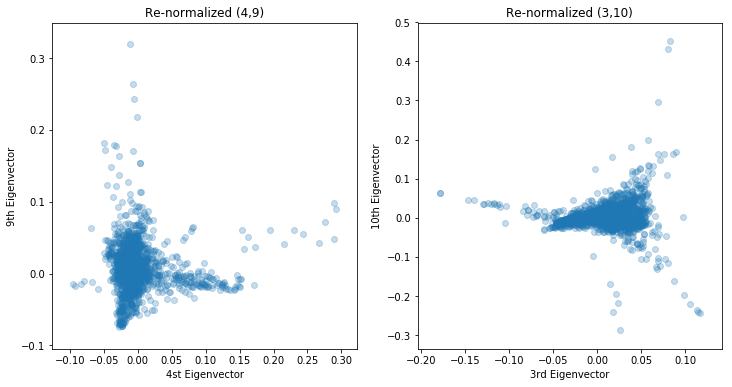

In [121]:
# Your code here.
plt.figure(figsize=(12,6))

x1= eigen_deg_norm[:,4]
y1= eigen_deg_norm[:,9]

plt.subplot(1,2,1)
plt.scatter(x1, y1, alpha=0.25)
plt.title("Re-normalized (4,9)")
plt.xlabel("4st Eigenvector")
plt.ylabel("9th Eigenvector")

x2= eigen_deg_norm[:,3]
y2= eigen_deg_norm[:,10]

plt.subplot(1,2,2)
plt.scatter(x2, y2, alpha=0.25)
plt.title("Re-normalized (3,10)")
plt.xlabel("3rd Eigenvector")
plt.ylabel("10th Eigenvector")

Both 2D plots shows that our graph is composed of one big cluster and some "branches" elongated along the eigenvector axis. Nevertheless, it's quite difficult to imagine real clusters at this point since we're reducing the dimension of the network from 1000+ to 2.

### Question 9

What does the embedding $Z \in \mathbb{R}^{N \times d}$ preserve?

The embedding preserves the local distances between the vertices.

## 2 Spectral clustering

*Spectral clustering* is a method to partition a graph into distinct clusters.
The method associates a feature vector $z_i \in \mathbb{R}^d$ to every node $v_i \in \mathcal{V}$, then runs [$k$-means](https://en.wikipedia.org/wiki/K-means_clustering) in the embedding space $\mathbb{R}^d$ to assign each node $v_i \in \mathcal{V}$ to a cluster $c_j \in \mathcal{C}$, where $k = |\mathcal{C}|$ is the number of desired clusters.

### Question 10

Choose $k$ and $d$. How did you get to those numbers?

We choose k from observing the spectrum of our graph. As we saw in the lecture, the index of the eigenvalue (of the normalized Laplacian) at which there is a gap (a discontinuity in the spectrum) is a good choice for the number of clusters. We choose d experimentaly by looking at the best cluster assignmnent for values slightly higher than k.

### Question 11

1. Embed your graph in $\mathbb{R}^d$ as $Z \in \mathbb{R}^{N \times d}$.
   Try with and without re-normalizing the eigenvectors by the degrees, then keep the one your prefer.
1. If you want $k=2$ clusters, partition with the Fiedler vector. For $k > 2$ clusters, run $k$-means on $Z$. Don't implement $k$-means, use the `KMeans` class imported from scikit-learn.

In [122]:
number_eigenvectors=12
k=10

H=eigen_deg_norm[:,1:number_eigenvectors]

K_means=KMeans(n_clusters = k, random_state=0).fit(H)

labs=[]

for i in range(k):
    labs.append(len(np.argwhere(K_means.labels_ == i)))
    print('Cluster',i,'has',labs[i],'elements')

labels=K_means.labels_

Cluster 0 has 187 elements
Cluster 1 has 541 elements
Cluster 2 has 122 elements
Cluster 3 has 13 elements
Cluster 4 has 20 elements
Cluster 5 has 2 elements
Cluster 6 has 3 elements
Cluster 7 has 7 elements
Cluster 8 has 636 elements
Cluster 9 has 37 elements


### Question 12

Use the computed cluster assignment to reorder the adjacency matrix $A$.
What do you expect? What do you observe?

Text(0.5, 1.05, 'adjacency matrix')

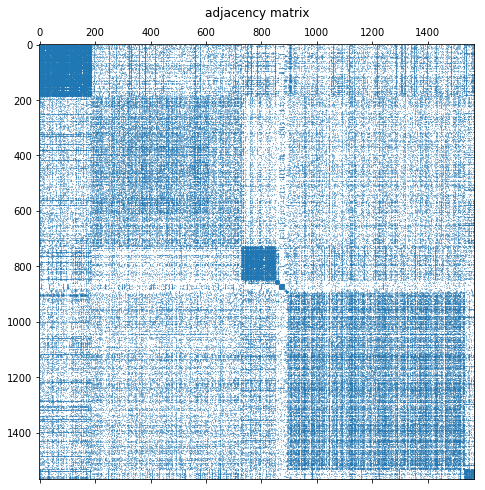

In [123]:
sort_by_cluster=np.argsort(labels)
feat_red['cluster'] = labels
feat_red['index_by_cluster']=np.argsort(sort_by_cluster)
feat_red.sort_values('index_by_cluster')

adjacency_sorted=adjacency_red[sort_by_cluster,:]
adjacency_sorted=adjacency_sorted[:,sort_by_cluster]

plt.figure(figsize=(8,8))
plt.spy(adjacency_sorted, markersize=0.1)
plt.title('adjacency matrix')

**Your answer here.**

### Question 13

If you have ground truth clusters for your dataset, compare the cluster assignment from spectral clustering to the ground truth.
A simple quantitative measure is to compute the percentage of nodes that have been correctly categorized.
If you don't have a ground truth, qualitatively assess the quality of the clustering.

Ground truth clusters are the "real clusters".
For example, the genre of musical tracks in FMA, the category of Wikipedia articles, the spammer status of individuals, etc.
Look for the `labels` in the [dataset descriptions](https://github.com/mdeff/ntds_2018/tree/master/projects/README.md).

In [137]:
print(feat_red[feat_red.cluster == 3].title)

114                                        Star Trek
158     Star Wars: Episode III - Revenge of the Sith
162        Star Wars: Episode I - The Phantom Menace
446                               Star Trek: Nemesis
569                         Star Trek: First Contact
689                    Star Trek: The Motion Picture
738                               Return of the Jedi
779                  Star Trek V: The Final Frontier
840           Star Trek VI: The Undiscovered Country
907                    Star Trek IV: The Voyage Home
914                          The Empire Strikes Back
1178                 Star Trek II: The Wrath of Khan
1204                                       Star Wars
Name: title, dtype: object


As seen on the above Star Wars/Trek example, some clusters are very well defined based on their main themes (keywords like spacecraft, space, etc).

In [147]:
print(feat_red[feat_red.cluster == 1][:15].title)

13     The Chronicles of Narnia: Prince Caspian
19                           The Golden Compass
21                                      Titanic
40                            The Good Dinosaur
43                            A Christmas Carol
48                                         Hugo
54                              The Jungle Book
62                            The Polar Express
78                                 Pearl Harbor
80                                    Alexander
85            Charlie and the Chocolate Factory
86                                  Ratatouille
106                                        Troy
109                                     Beowulf
110                             Kung Fu Panda 3
Name: title, dtype: object


This example shows the first 15 movies of the second cluster. As seen on question 12 plot, this cluster is less dense than other clusters and themes and genres looks less defined than in other clusters (see example above).

### Question 14

Plot the cluster assignment (one color per cluster) on the 2D embedding you computed above with Laplacian eigenmaps.

Text(0, 0.5, '10th Eigenvector')

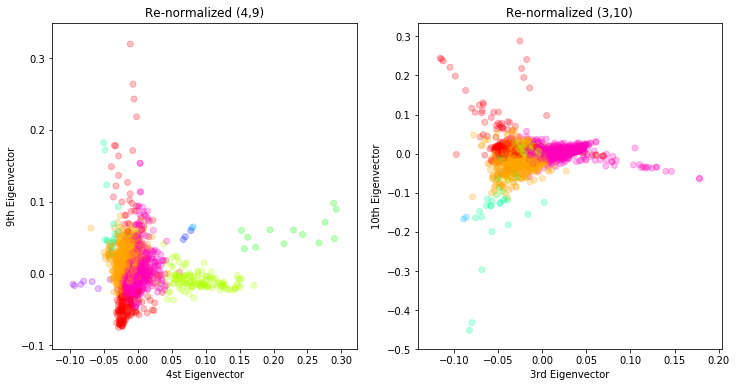

In [51]:
# Your code here.
plt.figure(figsize=(12,6))

x1= eigen_deg_norm[:,4]
y1= eigen_deg_norm[:,9]

plt.subplot(1,2,1)
plt.scatter(x1, y1, alpha=0.25, c=K_means.labels_, cmap='hsv')
plt.title("Re-normalized (4,9)")
plt.xlabel("4st Eigenvector")
plt.ylabel("9th Eigenvector")

x2= eigen_deg_norm[:,3]
y2= eigen_deg_norm[:,10]

plt.subplot(1,2,2)
plt.scatter(x2, y2, alpha=0.25, c=K_means.labels_, cmap='hsv')
plt.title("Re-normalized (3,10)")
plt.xlabel("3rd Eigenvector")
plt.ylabel("10th Eigenvector")

### Question 15

Why did we use the eigenvectors of the graph Laplacian as features? Could we use other features for clustering?

**Your answer here.**